
# Simulazione di caching basato su similarità di prompt (CLIP) con due politiche di eviction: LRU e LFU



In [35]:

import random
import itertools
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
from collections import defaultdict
from transformers import CLIPTokenizer, CLIPModel
import torch.nn.functional as F
from sklearn.cluster import KMeans



### Setup device (MPS su Mac, altrimenti CPU)


In [36]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS device")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA device: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")
    print("Using CPU device")

Using Apple MPS device


## Gestione del dataset

In [37]:
from typing import Dict, List, Optional, Tuple, Union
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import random

class PromptDatasetManager:
    def __init__(self):
        self.df: pd.DataFrame = None
        self.emb_matrix: np.ndarray = None
        self.prompts_arr: np.ndarray = None
        self.embs_arr: np.ndarray = None
        self.user_to_idx: dict[str, np.ndarray] = {}
        self.session_to_idx: dict[tuple[str,int], np.ndarray] = {}

    def load_local_metadata(
        self,
        path: str,
        max_rows: Optional[int] = None,
        load_embeddings: bool = True
    ):
        # 1) Lettura Parquet
        cols = ['prompt','clip_emb','user_name','timestamp']
        table = pq.read_table(path, columns=cols)
        if max_rows:
            table = table.slice(0, max_rows)
        self.df = table.to_pandas()
        # 2) Timestamp -> datetime
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
        # 3) Embedding matrix
        if load_embeddings:
            self.emb_matrix = np.vstack(self.df['clip_emb'].values).astype(np.float32)
        else:
            N = len(self.df)
            self.emb_matrix = np.zeros((N,0), dtype=np.float32)
        # 4) Prompt array
        self.prompts_arr = self.df['prompt'].to_numpy(dtype=object)
        # 5) Precompute sorted order and delta
        self._precompute_sorted()
        # 6) Global time order for sample_prompts
        self.time_sorted_idx = self.df.sort_values('timestamp').index.to_numpy()
        # 7) Build user->indices map
        self._build_user_indices()

    def _precompute_sorted(self):
        """
        Ordina per user_name, timestamp e calcola delta (minuti) tra record consecutivi.
        """
        order = self.df.sort_values(['user_name','timestamp']).index.to_numpy()
        self.sorted_idx = order
        users = self.df['user_name'].to_numpy()[order]
        # Estrai timestamps come datetime64[ns] e ordina
        times = self.df['timestamp'].to_numpy(dtype='datetime64[ns]')[order]
        # Converti a nanosecondi interi
        ts_int = times.astype('int64')
        # Differenze consecutive in ns -> minuti
        dt_ns = ts_int[1:] - ts_int[:-1]
        dt_min = dt_ns.astype(np.float32) / 1e9 / 60.0
        # Assegna delta
        delta = np.empty(len(order), dtype=np.float32)
        delta[0] = np.inf
        same = users[1:] == users[:-1]
        delta[1:] = np.where(same, dt_min, np.inf)
        self.sorted_delta = delta

    def _build_user_indices(self):
        groups = self.df.groupby('user_name', sort=False).indices
        self.user_to_idx = {u: np.asarray(idxs, dtype=np.int32) for u, idxs in groups.items()}


    # -----------------------
    #   FUNZIONI VELOCI
    # -----------------------

    def sample_sessions(
        self,
        gap: float,
        num_sessions: Optional[int] = None,
        max_prompts: Optional[int] = None,
        random_order: bool = False
    ) -> List[Tuple[np.ndarray, np.ndarray]]:
        """
        Campiona sessioni definite da gap (minuti) tra prompt dello stesso user:
        - gap: soglia per separare sessioni
        - num_sessions=None -> tutte le sessioni (in ordine se random_order=False)
                       else -> campione casuale o primi
        - max_prompts=None -> tutti i prompt
                       else -> primi max_prompts di ogni sessione
        - random_order=False -> restituisce in ordine sequenziale di apparizione
        """
        # 1) breakpoints dove gap superato
        breaks = np.nonzero(self.sorted_delta > gap)[0]
        starts = np.concatenate(([0], breaks + 1))
        ends   = np.concatenate((breaks, [len(self.sorted_delta) - 1]))
        segments = list(zip(starts, ends))
        # 2) campionamento
        if num_sessions is not None and num_sessions < len(segments):
            if random_order:
                segments = random.sample(segments, num_sessions)
            else:
                segments = segments[:num_sessions]
        # 3) estrai batches
        out = []
        for s, e in segments:
            length = e - s + 1
            take = length if max_prompts is None else min(length, max_prompts)
            idxs = self.sorted_idx[s:s+take]
            out.append((self.prompts_arr[idxs], self.emb_matrix[idxs]))
        return out

    def sample_user_prompts(
        self,
        num_users: Optional[int] = None,
        random_order: bool = True,
        per_user: bool = False
    ) -> Union[List[Tuple[str, np.ndarray]], Dict[str, List[Tuple[str, np.ndarray]]]]:
        """
        Campiona prompt per un sottoinsieme di utenti:
        - num_users=None -> tutti gli utenti; altrimenti scegli num_users utenti (random o sequenziali)
        - per_user=False -> lista unica di (prompt, emb) concatenata per gli utenti selezionati
        - per_user=True  -> dict user->lista di (prompt, emb)
        - random_order=True/False determina l'ordine dei prompt per ciascun utente
        """
        # Seleziona utenti
        users = list(self.user_to_idx.keys())
        if num_users is not None and num_users < len(users):
            if random_order:
                selected_users = random.sample(users, num_users)
            else:
                selected_users = users[:num_users]
        else:
            selected_users = users

        # Prepara output
        if per_user:
            out: Dict[str, List[Tuple[str, np.ndarray]]] = {}
        else:
            out: List[Tuple[str, np.ndarray]] = []

        # Per ciascun utente selezionato, estrai tutti i prompt
        for user in selected_users:
            idxs = self.user_to_idx.get(user, np.array([], dtype=int))
            if idxs.size == 0:
                if per_user:
                    out[user] = []
                continue
            # eventualmente mescola i prompt per utente
            order = np.random.permutation(idxs) if random_order else idxs
            items = [(self.prompts_arr[i], self.emb_matrix[i]) for i in order]
            if per_user:
                out[user] = items
            else:
                out.extend(items)

        return out

    def sample_prompts(
        self,
        num_prompts: Optional[int] = None,
        random_order: bool = True
    ) -> List[Tuple[str, np.ndarray]]:
        """
        Campiona prompt globali:
        - num_prompts=None -> tutti
        - num_prompts=k    -> primi k in sequenza o k random
        - random_order=False -> sequenza cronologica globale (timestamp)
        - random_order=True  -> shuffle
        """
        N = len(self.prompts_arr)
        if random_order:
            k = min(num_prompts, N) if num_prompts is not None else N
            idxs = np.random.choice(N, size=k, replace=False)
        else:
            # indice solo per timestamp
            time_order = self.df.sort_values('timestamp').index.to_numpy()
            idxs = time_order if num_prompts is None else time_order[:num_prompts]
        return [(self.prompts_arr[i], self.emb_matrix[i]) for i in idxs]


In [38]:
manager = PromptDatasetManager()

In [39]:
manager.load_local_metadata(
    path="/Users/tella/Workspace/Inria/Data/normalized_embeddings.parquet",
    max_rows=None # Limita per testare velocemente
)

In [40]:
print(f"Colonne disponibili: {list(manager.df.columns)}")
print((manager.df.head(5)))

Colonne disponibili: ['prompt', 'clip_emb', 'user_name', 'timestamp']
                                              prompt  \
0  a portrait of a female robot made from code, v...   
1  a portrait of a female robot made from a cloud...   
2      only memories remain, trending on artstation    
3                   dream swimming pool with nobody    
4           a dog doing weights. epic oil painting.    

                                            clip_emb  \
0  [0.0014396037, 0.009074121, -0.07621925, -0.01...   
1  [0.023341777, 0.014913292, -0.10948194, -0.000...   
2  [-0.018536763, -0.029404927, -0.048680052, 0.0...   
3  [0.019796269, -0.025657006, -0.03839434, 0.004...   
4  [0.026751772, 0.0011126306, -0.041311223, 0.04...   

                                           user_name                 timestamp  
0  0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd... 2022-08-20 11:56:00+00:00  
1  0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd... 2022-08-20 11:59:00+00:00  
2  0167cc490c

In [41]:
sessions = manager.sample_sessions(num_sessions=50, max_prompts=10, gap=30, random_order=True)
print(f"Loaded {len(sessions)} sessions.")
user_pairs = manager.sample_user_prompts(num_users=10, random_order=True, per_user=True)
print(f"Loaded {len(user_pairs)} user pairs.")
random_pairs = manager.sample_prompts(num_prompts=50, random_order=True)
print(f"Loaded {len(random_pairs)} random pairs.")


Loaded 50 sessions.
Loaded 10 user pairs.
Loaded 50 random pairs.


In [42]:
sessions = manager.sample_sessions(num_sessions=None, max_prompts=None, gap=30)
print(f"Loaded {len(sessions)} sessions.")
user_pairs = manager.sample_user_prompts(num_users=None, random_order=False, per_user=False)
print(f"Loaded {len(user_pairs)} user pairs.")
random_pairs = manager.sample_prompts(num_prompts=None, random_order=False)
print(f"Loaded {len(random_pairs)} random pairs.")

Loaded 145700 sessions.
Loaded 1999884 user pairs.
Loaded 2000000 random pairs.


## Valutazione della similarità intra-sessione, extra-sessione e same-user

In [43]:
def compute_intra_session_sims(
    manager,
    num_sessions: Optional[int] = None,
    max_prompts: Optional[int] = None,
    session_gap: int = 30,
    random_order: bool = True
) -> np.ndarray:
    """
    • Se num_sessions=None: tutte le sessioni, altrimenti ne estrae casuali/ordine.
    • Se max_prompts=None: tutti i prompt di ciascuna sessione, altrimenti limita.
    Ritorna array concatenato di dot‑product tra embeddings consecutive per sessione.
    """
    batches = manager.sample_sessions(
        num_sessions=num_sessions,
        max_prompts=max_prompts,
        random_order=random_order,
        gap=session_gap
    )
    sims_list = []
    for _, embs in batches:
        if embs.shape[0] < 2:
            continue
        M = embs if max_prompts is None else embs[:max_prompts]
        # dot tra righe consecutive
        dots = np.einsum('ij,ij->i', M[1:], M[:-1])
        sims_list.append(dots)
    return np.concatenate(sims_list) if sims_list else np.array([])


def compute_user_sims(
    manager,
    num_users: Optional[int] = None,
    random_order: bool = True
) -> np.ndarray:
    """
    • Se num_prompts=None: per ogni utente prende tutti i suoi prompt in ordine.
    • Altrimenti estrae num_prompts per utente (random o sequenziale).
    Ritorna array concatenato dei dot‑product tra embeddings consecutive per utente.
    """
    user_dict = manager.sample_user_prompts(
        num_users=num_users,
        random_order=random_order,
        per_user=True
    )
    sims_list = []
    for items in user_dict.values():
        if len(items) < 2:
            continue
        embs = np.stack([emb for _, emb in items], axis=0)
        dots = np.einsum('ij,ij->i', embs[1:], embs[:-1])
        sims_list.append(dots)
    return np.concatenate(sims_list) if sims_list else np.array([])


def compute_random_sims(
    manager,
    num_prompts: Optional[int] = None,
    random_order: bool = True
) -> np.ndarray:
    """
    • Se num_prompts=None: prende tutti i prompt in ordine (o shuffled se random_order=True).
    • Altrimenti estrae num_prompts a caso o sequenziali.
    Ritorna array di dot‑product tra embeddings consecutive nell’array risultante.
    """
    items = manager.sample_prompts(
        num_prompts=num_prompts,
        random_order=random_order
    )
    if len(items) < 2:
        return np.array([])
    embs = np.stack([emb for _, emb in items], axis=0)
    return np.einsum('ij,ij->i', embs[1:], embs[:-1])


In [44]:
intra = compute_intra_session_sims(manager, num_sessions=None, max_prompts=None, session_gap=30, random_order=True)
print(f"Loaded {len(intra)} intra-session similarities.")
print(f"Mean intra-session similarity: {np.mean(intra) if len(intra) > 0 else 0.0}")
user = compute_user_sims(manager, num_users=None, random_order=True)
print(f"Loaded {len(user)} user similarities.")
print(f"Mean user similarity: {np.mean(user) if len(user) > 0 else 0.0}")
rand = compute_random_sims(manager, num_prompts=None, random_order=True)
print(f"Loaded {len(rand)} random similarities.")
print(f"Mean random similarity: {np.mean(rand) if len(rand) > 0 else 0.0}")

Loaded 1854300 intra-session similarities.
Mean intra-session similarity: 0.7907183170318604
Loaded 1989708 user similarities.
Mean user similarity: 0.44582948088645935
Loaded 1999999 random similarities.
Mean random similarity: 0.32383760809898376


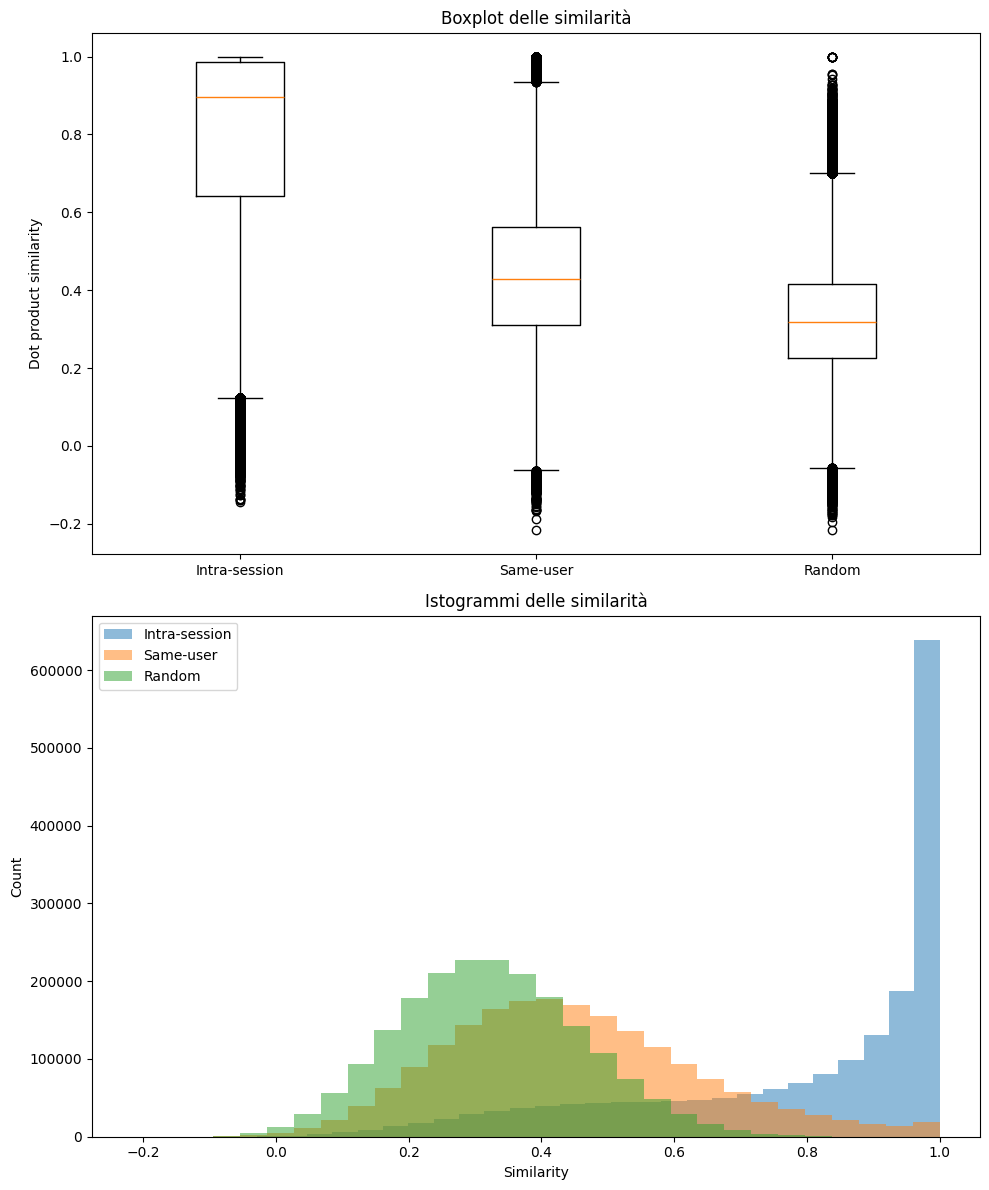

In [45]:

# Histo + boxplot
def plot_distributions(intra, user, rand):
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))

    # Boxplot comparativo\    
    axs[0].boxplot([intra, user, rand], tick_labels=['Intra-session', 'Same-user', 'Random'])
    axs[0].set_title('Boxplot delle similarità')
    axs[0].set_ylabel('Dot product similarity')

    # Istogrammi affiancati
    N, bins = 1, 30
    axs[1].hist(intra, bins=bins, alpha=0.5, label='Intra-session')
    axs[1].hist(user, bins=bins, alpha=0.5, label='Same-user')
    axs[1].hist(rand, bins=bins, alpha=0.5, label='Random')
    axs[1].set_title('Istogrammi delle similarità')
    axs[1].set_xlabel('Similarity')
    axs[1].set_ylabel('Count')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_distributions(intra, user, rand)


Loaded 6 session gaps.
Means by gap: [np.float32(0.7963676), np.float32(0.79320544), np.float32(0.79146725), np.float32(0.7907183), np.float32(0.78964514), np.float32(0.7887222)]


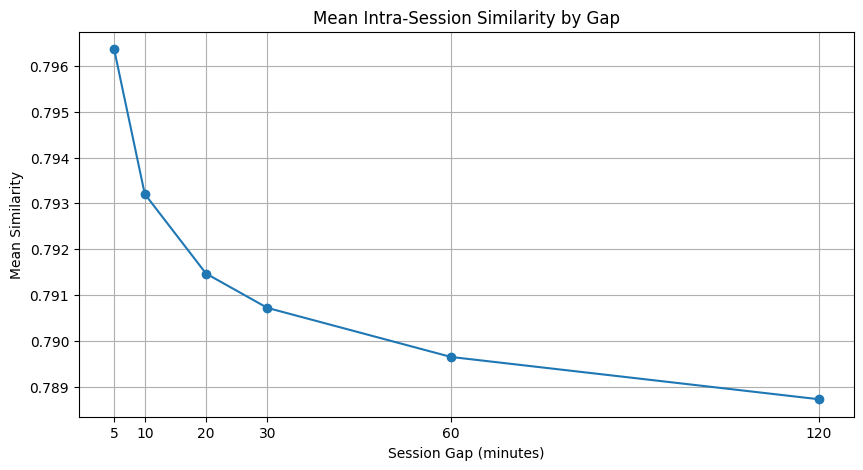

In [46]:
session_gaps = [5, 10, 20, 30, 60, 120]

sims_by_gap = [np.mean(compute_intra_session_sims(manager, num_sessions=None, session_gap=gap, max_prompts=None)) for gap in session_gaps]
print (f"Loaded {len(sims_by_gap)} session gaps.")
print (f"Means by gap: {sims_by_gap}")
# plot sims_by_gap
plt.figure(figsize=(10, 5))
plt.plot(session_gaps, sims_by_gap, marker='o')
plt.title('Mean Intra-Session Similarity by Gap')
plt.xlabel('Session Gap (minutes)')
plt.ylabel('Mean Similarity')
plt.xticks(session_gaps)
plt.grid()
plt.show()

## Cache similarity con politiche di eviction

LRU (Least Recently Used) e LFU (Least Frequently Used) e TTL (Time To Live) per la gestione della cache.

In [47]:
import numpy as np
import faiss
from collections import OrderedDict, defaultdict
from typing import Dict, List, Tuple, Optional

class SimilarityIndex:
    """
    Wraps a FAISS inner-product index for fast nearest-neighbor search over embeddings.
    Maintains mapping from keys to embeddings and back.
    """
    def __init__(self, dim: int, use_faiss: bool = True):
        self.dim = dim
        self.use_faiss = use_faiss
        # key list in same order as index vectors
        self.keys: List[str] = []
        # linear store for fallback
        self.embs: List[np.ndarray] = []
        if self.use_faiss:
            # IndexFlatIP for inner-product similarity
            self.index = faiss.IndexFlatIP(dim)

    def add(self, key: str, emb: np.ndarray):
        """Add a new vector to the index."""
        vec = emb.reshape(1, -1).astype(np.float32)
        self.keys.append(key)
        self.embs.append(emb)
        if self.use_faiss:
            self.index.add(vec)

    def remove(self, key: str):
        """Remove a key (and its embedding) from the index. Requires rebuild."""
        # find position
        try:
            idx = self.keys.index(key)
        except ValueError:
            return
        # drop
        self.keys.pop(idx)
        self.embs.pop(idx)
        if self.use_faiss:
            # rebuild index
            self.index.reset()
            all_vecs = np.stack(self.embs).astype(np.float32)
            if len(all_vecs):
                self.index.add(all_vecs)

    def query(self, emb: np.ndarray, topk: int = 1) -> Tuple[Optional[str], float]:
        """
        Search for the most similar cached embedding to `emb`.
        Returns (best_key, best_sim).
        If cache empty, returns (None, -inf).
        """
        if not self.keys:
            return None, -np.inf
        vec = emb.reshape(1, -1).astype(np.float32)
        if self.use_faiss:
            D, I = self.index.search(vec, min(len(self.keys), topk))
            best_sim = float(D[0,0])
            best_key = self.keys[I[0,0]]
            return best_key, best_sim
        else:
            # linear scan
            best_key, best_sim = None, -np.inf
            for k, e in zip(self.keys, self.embs):
                sim = float(np.dot(e, emb))
                if sim > best_sim:
                    best_sim = sim
                    best_key = k
            return best_key, best_sim

class BaseSimilarityCache:
    """
    Abstract base for similarity caches: uses SimilarityIndex for similarity search
    and defers eviction policy to subclasses via _evict_if_needed.
    """
    def __init__(self,
                 capacity: int,
                 threshold: float,
                 dim: int,
                 use_faiss: bool = True):
        self.capacity = capacity
        self.threshold = threshold
        self.index = SimilarityIndex(dim, use_faiss)

    def query(self, key: str, emb: np.ndarray) -> bool:
        """
        Query the cache with embedding:
        - If best_sim >= threshold: hit (and update policy metadata)
        - Else: miss (evict if needed, then add)
        Returns True on hit, False on miss.
        """
        best_key, best_sim = self.index.query(emb)
        if best_sim >= self.threshold:
            self._on_hit(best_key)
            return True
        else:
            self._on_miss(key, emb)
            return False

    def _on_hit(self, key: str):
        """Called on cache hit: update metadata."""
        raise NotImplementedError

    def _on_miss(self, key: str, emb: np.ndarray):
        """Called on cache miss: evict if needed and add new entry."""
        if len(self.index.keys) >= self.capacity:
            evict_key = self._select_eviction()
            self.index.remove(evict_key)
            self._on_evict(evict_key)
        self.index.add(key, emb)
        self._on_add(key)

    def _select_eviction(self) -> str:
        """Select a key to evict according to policy."""
        raise NotImplementedError

    def _on_add(self, key: str):
        """Hook for subclasses when adding a key."""
        pass

    def _on_evict(self, key: str):
        """Hook for subclasses when evicting a key."""
        pass

In [48]:
# --- Simulation harness for live monitoring ---
class CacheSimulator:
    """
    Runs a sequence of requests through a cache policy and reports live metrics.
    """
    def __init__(self, cache: BaseSimilarityCache, total_requests: int, report_interval: int = 100):
        self.cache = cache
        self.total = total_requests
        self.interval = report_interval
        self.hits = 0
        self.requests = 0

    def run(self, requests: List[Tuple[str, np.ndarray]]):
        """Process requests and print live status every interval."""
        for idx, (key, emb) in enumerate(requests, start=1):
            if self.cache.query(key, emb):
                self.hits += 1
            self.requests += 1
            if idx % self.interval == 0 or idx == len(requests):
                occupancy = len(self.cache.index.keys)
                hit_rate = self.hits / self.requests
                print(f"Request {idx}/{len(requests)} | Hits: {self.hits} | "
                      f"HitRate: {hit_rate:.3f} | CacheSize: {occupancy}/{self.cache.capacity}")
        # final summary
        print(f"Simulation completed: {self.requests} requests, final HitRate: {self.hits/self.requests:.3f}")


    def _on_hit(self, key: str):
        self.last_seen[key] = self.time

    def _on_add(self, key: str):
        self.last_seen[key] = self.time

    def _select_eviction(self) -> str:
        # not used: eviction on miss picks oldest by time
        return min(self.last_seen, key=lambda k: self.last_seen[k])

In [49]:

class LRUCache(BaseSimilarityCache):
    """Least-Recently-Used eviction policy."""
    def __init__(self, capacity: int, threshold: float, dim: int, use_faiss: bool = True):
        super().__init__(capacity, threshold, dim, use_faiss)
        from collections import OrderedDict
        self.order = OrderedDict()  # key -> None

    def _on_hit(self, key: str):
        # move to end = most recently used
        self.order.move_to_end(key)

    def _on_add(self, key: str):
        self.order[key] = None

    def _on_evict(self, key: str):
        del self.order[key]

    def _select_eviction(self) -> str:
        # least recently used = first key
        return next(iter(self.order))

class LFUCache(BaseSimilarityCache):
    """Least-Frequently-Used eviction policy."""
    def __init__(self, capacity: int, threshold: float, dim: int, use_faiss: bool = True):
        super().__init__(capacity, threshold, dim, use_faiss)
        self.freq = defaultdict(int)

    def _on_hit(self, key: str):
        self.freq[key] += 1

    def _on_add(self, key: str):
        self.freq[key] = 1

    def _on_evict(self, key: str):
        del self.freq[key]

    def _select_eviction(self) -> str:
        # key with minimal freq
        return min(self.freq, key=lambda k: self.freq[k])

class TTLCache(BaseSimilarityCache):
    """Time-to-Live eviction: removes entries not seen in last ttl requests."""
    def __init__(
        self,
        capacity: int,
        threshold: float,
        dim: int,
        ttl: int,
        use_faiss: bool = True
    ):
        super().__init__(capacity, threshold, dim, use_faiss)
        self.ttl = ttl
        self.time = 0
        self.last_seen = {}  # key -> last request time

    def query(self, key: str, emb: np.ndarray) -> bool:
        # expire old entries first
        expired = [k for k, t in self.last_seen.items() if self.time - t > self.ttl]
        for k in expired:
            self.index.remove(k)
            del self.last_seen[k]
        hit = super().query(key, emb)
        # update time
        self.time += 1
        return hit

    def _on_hit(self, key: str):
        self.last_seen[key] = self.time

    def _on_add(self, key: str):
        self.last_seen[key] = self.time

    def _select_eviction(self) -> str:
        # not used: eviction on miss picks oldest by time
        return min(self.last_seen, key=lambda k: self.last_seen[k])


In [50]:
# inizializzazione
dim = manager.emb_matrix.shape[1]
print(dim)
lru = LRUCache(capacity=500, threshold=0.8, dim=dim)
# query con embedding già prelevato
prompt, emb = manager.sample_prompts(num_prompts=1)[0]
hit = lru.query(prompt, emb)

512


In [51]:
seq_requests = manager.sample_prompts(num_prompts=None, random_order=False)
rand_requests = manager.sample_prompts(num_prompts=None, random_order=True)


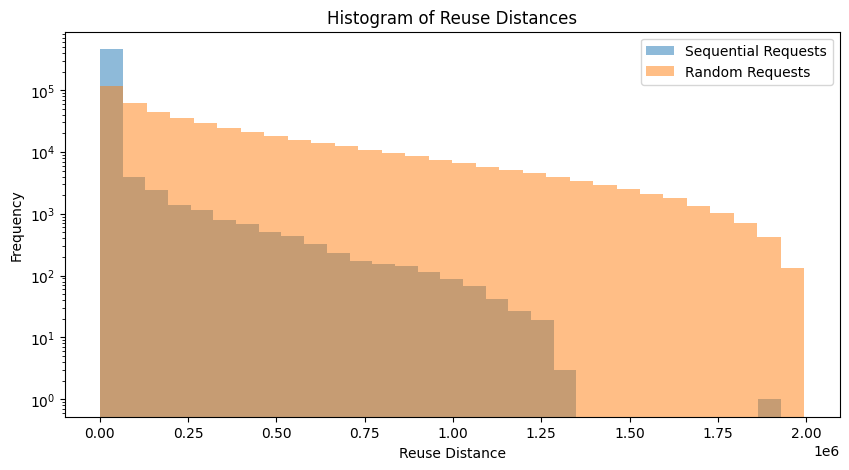

In [52]:

def compute_reuse_dist(requests: List[str]) -> List[int]:
    last = {}
    deltas = []
    for i, p in enumerate(requests):
        if p in last:
            deltas.append(i - last[p])
        last[p] = i
    return deltas

reuse_seq = compute_reuse_dist([p for p,_ in seq_requests])
reuse_rand = compute_reuse_dist([p for p,_ in rand_requests])

# Plot histogram of reuse distances (log scale)
plt.figure(figsize=(10, 5))
plt.hist(reuse_seq, bins=30, alpha=0.5, label='Sequential Requests', log=True)
plt.hist(reuse_rand, bins=30, alpha=0.5, label='Random Requests', log=True)
plt.title('Histogram of Reuse Distances')
plt.xlabel('Reuse Distance')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
# impostazioni
dim = manager.emb_matrix.shape[1]
cache = LRUCache(capacity=500, threshold=0.8, dim=dim)
# prepari la sequenza di richieste
requests = manager.sample_prompts(num_prompts=2000, random_order=False)
# simuli con report ogni 200 richieste
sim = CacheSimulator(cache, total_requests=len(requests), report_interval=200)
sim.run(requests)

Request 200/2000 | Hits: 48 | HitRate: 0.240 | CacheSize: 152/500
Request 400/2000 | Hits: 109 | HitRate: 0.273 | CacheSize: 291/500
Request 600/2000 | Hits: 181 | HitRate: 0.302 | CacheSize: 419/500
Request 800/2000 | Hits: 244 | HitRate: 0.305 | CacheSize: 500/500
Request 1000/2000 | Hits: 312 | HitRate: 0.312 | CacheSize: 500/500
Request 1200/2000 | Hits: 377 | HitRate: 0.314 | CacheSize: 500/500
Request 1400/2000 | Hits: 440 | HitRate: 0.314 | CacheSize: 500/500
Request 1600/2000 | Hits: 496 | HitRate: 0.310 | CacheSize: 500/500
Request 1800/2000 | Hits: 550 | HitRate: 0.306 | CacheSize: 500/500
Request 2000/2000 | Hits: 624 | HitRate: 0.312 | CacheSize: 500/500
Simulation completed: 2000 requests, final HitRate: 0.312


In [ ]:
import panel as pn
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

# Assicurati di aver già importato le cache e il manager
# from similarity_caches import LRUCache, LFUCache, TTLCache
# from prompt_dataset_manager import PromptDatasetManager

pn.extension()
dim = manager.emb_matrix.shape[1]

# Prepara le due trace
TRACE_LEN = 10
seq_requests = manager.sample_prompts(num_prompts=TRACE_LEN, random_order=False)
rand_requests = manager.sample_prompts(num_prompts=TRACE_LEN, random_order=True)

# Widget di controllo
policy_select   = pn.widgets.Select(name='Policy',    options=['LRU','LFU','TTL'],     value='LRU')
capacity_slider = pn.widgets.IntSlider(name='Capacity', start=50, end=2000, step=50, value=500)
threshold_slider= pn.widgets.FloatSlider(name='Threshold', start=0.5, end=1.0, step=0.05, value=0.8)
ttl_slider      = pn.widgets.IntSlider(name='TTL',      start=10, end=500, step=10,    value=100)
trace_select    = pn.widgets.RadioButtonGroup(name='Trace', options=['Sequential','Random'], button_type='primary')
run_button      = pn.widgets.Button(name='Run Simulation', button_type='success')

# Output
text_hit_rate   = pn.widgets.StaticText(name='Hit Rate', value='0.00')
text_cache_size = pn.widgets.StaticText(name='Cache Occupancy', value='0')

plot_pane = pn.pane.Matplotlib(sizing_mode='stretch_width', height=300)

def run_simulator(event):
    # Seleziona trace
    requests = seq_requests if trace_select.value=='Sequential' else rand_requests

    # Instanzia cache scelto
    cap, th, ttl = capacity_slider.value, threshold_slider.value, ttl_slider.value
    if policy_select.value=='LRU':
        cache = LRUCache(cap, th, dim, use_faiss=True)
    elif policy_select.value=='LFU':
        cache = LFUCache(cap, th, dim, use_faiss=True)
    else:
        cache = TTLCache(cap, th, dim, ttl, use_faiss=True)

    hits, sizes = 0, []
    rates = []
    for i, (key, emb) in enumerate(requests, start=1):
        if cache.query(key, emb):
            hits += 1
        sizes.append(len(cache.index.keys))
        rates.append(hits / i)

    # Aggiorna metriche testuali
    text_hit_rate.value   = f"{rates[-1]:.3f}"
    text_cache_size.value = f"{sizes[-1]}/{cache.capacity}"

    # Disegna grafico
    plt.figure(figsize=(8,3))
    plt.plot(rates, label='Hit Rate')
    plt.plot(np.array(sizes)/cache.capacity, label='Occupancy (%)')
    plt.legend(loc='upper right')
    plt.xlabel('Request')
    plt.tight_layout()
    plot_pane.object = plt.gcf()

run_button.on_click(run_simulator)

# Layout e visualizzazione
dashboard = pn.Column(
    pn.Row(policy_select, capacity_slider, threshold_slider, ttl_slider, trace_select),
    run_button,
    pn.Row(text_hit_rate, text_cache_size),
    plot_pane
)

dashboard.servable(title='Similarity Cache Simulator')
dashboard.show()  # Per visualizzare direttamente nel browser, se necessario
# Per eseguire in un Jupyter Notebook, usa: dashboard.show() o dashboard.serv


BokehModel(combine_events=True, render_bundle={'docs_json': {'613c68d1-220a-42ad-b6d4-dcb17422c89a': {'version…

In [ ]:
from tqdm import tqdm
import pandas as pd
from itertools import product

capacities = [100]  # , 500, 1000]
thresholds = [0.7]  # , 0.8, 0.9]
ttls       = [10, 50, 100]

rows = []

# Outer tqdm su pattern
for pattern, reqs in tqdm(
    [('Seq', seq_requests), ('Rand', rand_requests)],
    desc="Trace pattern"
):
    # Middle tqdm su (capacity, threshold)
    print(f"Testing pattern: {pattern}")
    print(f"Requests: {len(reqs)}")
    for cap, th in tqdm(
        product(capacities, thresholds),
        desc=f"Params (cap,th)",
        leave=False
    ):
        print(f"Testing capacity={cap}, threshold={th}")
        # Inner loop su politiche
        for CacheCls, extra in [
            (LRUCache, {}), (LFUCache, {}), (TTLCache, {'ttl':50})
        ]:
            print (f"Testing {CacheCls.__name__} with extra={extra}")
            if CacheCls is TTLCache:
                for ttl in ttls:
                    hr, dt = test_cache(
                        TTLCache, reqs, cap, th, dim, ttl=ttl
                    )
                    rows.append([pattern, 'TTL', cap, th, ttl, hr, dt])
            else:
                hr, dt = test_cache(
                    CacheCls, reqs, cap, th, dim
                )
                rows.append([pattern, CacheCls.__name__, cap, th, None, hr, dt])

df = pd.DataFrame(
    rows,
    columns=['Pattern','Policy','Capacity','Thresh','TTL','HitRate','Time']
)


Trace pattern:   0%|          | 0/2 [00:00<?, ?it/s]

Testing pattern: Seq
Requests: 2000000


Testing capacity=100, threshold=0.7
Testing LRUCache with extra={}


Trace pattern:   0%|          | 0/2 [00:21<?, ?it/s]


KeyboardInterrupt: 

### Chaching test

In [ ]:
random.seed(42)
NUM_REQUESTS  = 1500      # numero di richieste da simulare
CACHE_SIZE    = 500      # dimensione cache
SIM_THRESHOLD = 0.8      # soglia di similarità
TTL_VALUES    = [10, 50, 100, 200]  # diversi TTL da testare

# prepariamo prompt generator
prompt_fn = manager.retRandomPrompt()

# funzioni di simulazione
def simulate_standard(cache_obj):
    hits = 0
    for _ in range(NUM_REQUESTS):
        p = prompt_fn()
        if cache_obj.query(p):
            hits += 1
    return hits / NUM_REQUESTS

def simulate_ttl(ttl):
    cache = SimilarityTTLCache(CACHE_SIZE, SIM_THRESHOLD, ttl)
    hits = 0
    for t in range(NUM_REQUESTS):
        p = prompt_fn()
        if cache.query(p, t):
            hits += 1
    return hits / NUM_REQUESTS

# esegui simulazioni
results = {}

# LRU e LFU
results["LRU"] = simulate_standard(SimilarityLRUCache(CACHE_SIZE, SIM_THRESHOLD))
results["LFU"] = simulate_standard(SimilarityLFUCache(CACHE_SIZE, SIM_THRESHOLD))

# TTL per vari parametri
for ttl in TTL_VALUES:
    results[f"TTL={ttl}"] = simulate_ttl(ttl)


KeyboardInterrupt: 

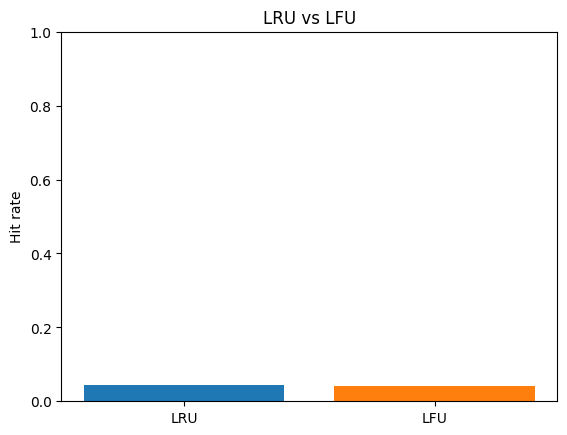

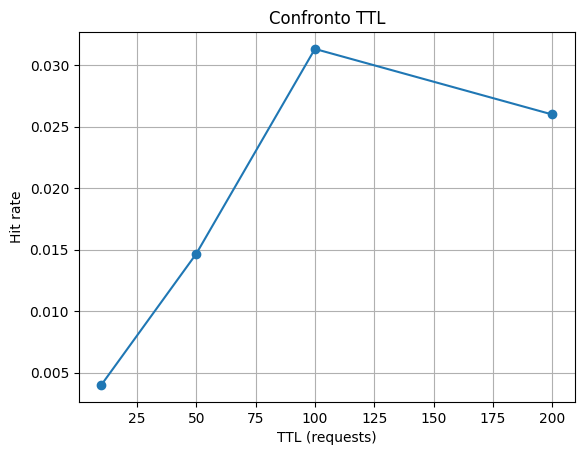

    policy  hit_rate
0      LRU  0.044667
1      LFU  0.040667
2   TTL=10  0.004000
3   TTL=50  0.014667
4  TTL=100  0.031333
5  TTL=200  0.026000


In [ ]:
# stampa tabella
df_res = pd.DataFrame([
    {"policy": k, "hit_rate": v} for k, v in results.items()
])

# separa LRU/LFU
plt.figure()
for pol in ["LRU", "LFU"]:
    hr = df_res[df_res.policy==pol].hit_rate.values[0]
    plt.bar(pol, hr)
plt.ylim(0,1)
plt.ylabel("Hit rate")
plt.title("LRU vs LFU")
plt.show()

# plot TTL
plt.figure()
ttl_rows = df_res[df_res.policy.str.startswith("TTL=")]
vals = [float(x.split("=")[1]) for x in ttl_rows.policy]
hrs  = ttl_rows.hit_rate.tolist()
plt.plot(vals, hrs, marker="o")
plt.xlabel("TTL (requests)")
plt.ylabel("Hit rate")
plt.title("Confronto TTL")
plt.grid(True)
plt.show()

print(df_res)


Caricati 100 prompt per la simulazione.
Simulazione LRU: cap=5, th=0.7
Simulazione LRU: cap=5, th=0.8
Simulazione LRU: cap=5, th=0.9
Simulazione LRU: cap=10, th=0.7
Simulazione LRU: cap=10, th=0.8
Simulazione LRU: cap=10, th=0.9
Simulazione LRU: cap=20, th=0.7
Simulazione LRU: cap=20, th=0.8
Simulazione LRU: cap=20, th=0.9
Simulazione LRU: cap=50, th=0.7
Simulazione LRU: cap=50, th=0.8
Simulazione LRU: cap=50, th=0.9


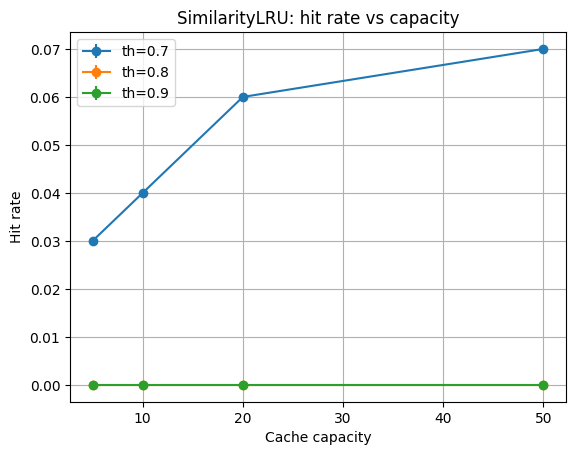

In [ ]:
def simulate_cache(cache_cls, capacity, threshold, workload, num_runs=3):
    metrics = {'hit_rate': [], 'evictions': [], 'comparisons': []}
    for _ in range(num_runs):
        cache = cache_cls(capacity=capacity, threshold=threshold)
        hits = evictions = comparisons = 0
        # opzionale: aggiungi cache.last_comparisons e cache.eviction_count
        for t, p in enumerate(workload):
            if cache.query(p):
                hits += 1
            # evictions += cache.eviction_count_delta
            # comparisons += cache.last_comparisons
        n = len(workload)
        metrics['hit_rate'].append(hits / n)
        metrics['evictions'].append(evictions)
        metrics['comparisons'].append(comparisons)
    # ritorna media e std
    return {
      k: (np.mean(v), np.std(v)) for k, v in metrics.items()
    }

# 1) prepara workload & embedding cache
raw_prompts = manager.getPrompts(limit=100, shuffle=True)
# precompute embeddings to speed up
emb_cache = {p: embed_prompt(p) for p in raw_prompts}
print (f"Caricati {len(raw_prompts)} prompt per la simulazione.")
# 2) definisci parametri
capacities = [5, 10, 20, 50]
thresholds = [0.7, 0.8, 0.9]

# 3) sweep su LRU
results = {}
for cap, th in itertools.product(capacities, thresholds):
    print(f"Simulazione LRU: cap={cap}, th={th}")
    workload = raw_prompts[:]  # o un sottoinsieme
    metrics = simulate_cache(SimilarityLRUCache, cap, th, workload)
    results[(cap, th)] = metrics

# 4) plot hit_rate vs capacity (una linea per threshold)
plt.figure()
for th in thresholds:
    rates = [results[(cap,th)]['hit_rate'][0] for cap in capacities]
    stds  = [results[(cap,th)]['hit_rate'][1] for cap in capacities]
    plt.errorbar(capacities, rates, yerr=stds, marker='o', label=f'th={th}')
plt.xlabel("Cache capacity")
plt.ylabel("Hit rate")
plt.title("SimilarityLRU: hit rate vs capacity")
plt.legend()
plt.grid(True)
plt.show()


Feature importance (η²):
  user_corr      → 0.7709
  session_corr   → 0.7492


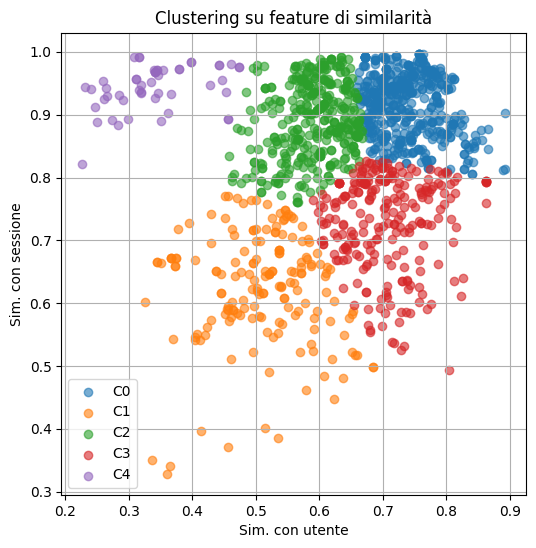

In [ ]:
# --- 1) Usa getSessionsPrompts per il gap di 30'
# manager.getSessionsPrompts(session_gap, limit, shuffle)
user_sessions = manager.getSessionsPrompts(session_gap=30, limit=2, shuffle=False)

# --- 2) Costruisci un DataFrame "flat" sessionale
rows = []
for user, sessions in user_sessions.items():
    for sess_id, prompts in sessions.items():
        for p in prompts:
            rows.append({
                'user_name': user,
                'prompt': p,
                'session_id': sess_id
            })
sess_df = pd.DataFrame(rows)

# --- 3) Calcola embedding per ogni prompt
# Nota: se hai molti duplicati, potresti dedup e poi merge, ma per chiarezza:
sess_df['emb'] = sess_df['prompt'].apply(lambda p: embed_prompt(p).squeeze())

# --- 4) Costruisci i prototipi medi
user_proto = sess_df.groupby('user_name')['emb'] \
                    .apply(lambda embs: torch.stack(embs.tolist()).mean(0))
session_proto = sess_df.groupby('session_id')['emb'] \
                       .apply(lambda embs: torch.stack(embs.tolist()).mean(0))

# funzione di similarità
def cos_sim(a, b):
    return F.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0), dim=1).item()

# --- 5) Calcola le due feature
sess_df['user_corr'] = sess_df.apply(
    lambda r: cos_sim(r['emb'], user_proto.loc[r['user_name']]),
    axis=1
)
sess_df['session_corr'] = sess_df.apply(
    lambda r: cos_sim(r['emb'], session_proto.loc[r['session_id']]),
    axis=1
)

# --- 6) Clustering (es. KMeans)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
sess_df['cluster'] = kmeans.fit_predict(sess_df[['user_corr','session_corr']])

# --- 7) η² per variabili numeriche
def eta_squared(x: pd.Series, clusters: pd.Series) -> float:
    mu = x.mean()
    ss_between = sum(
        (clusters == cl).sum() * (x[clusters == cl].mean() - mu)**2
        for cl in clusters.unique()
    )
    ss_total = ((x - mu)**2).sum()
    return float(ss_between / ss_total) if ss_total else 0.0

features = ['user_corr', 'session_corr']
etas = {f: eta_squared(sess_df[f], sess_df['cluster']) for f in features}

# --- 8) Risultati
print("Feature importance (η²):")
for feat, score in sorted(etas.items(), key=lambda kv: kv[1], reverse=True):
    print(f"  {feat:14s} → {score:.4f}")

# --- 9) (Opzionale) Scatter plot
plt.figure(figsize=(6,6))
for cl in range(n_clusters):
    sub = sess_df[sess_df['cluster']==cl]
    plt.scatter(sub['user_corr'], sub['session_corr'], alpha=0.6, label=f'C{cl}')
plt.xlabel("Sim. con utente")
plt.ylabel("Sim. con sessione")
plt.title("Clustering su feature di similarità")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def print_similarity_examples(
    manager,
    num_queries: int = 5,
    search_limit: int = 1000,
    threshold: float = 0.85
):
    """
    Estrae `search_limit` prompt dal manager, ne campiona `num_queries` come 
    domande, calcola embedding e per ognuna trova nel pool il prompt più simile 
    (escludendo se stesso). Se la similarità ≥ threshold, lo stampa.
    """
    # 1) Prendo un pool di prompt da cercare
    pool = manager.getPrompts(limit=search_limit, shuffle=True)
    if len(pool) < num_queries + 1:
        raise ValueError("Pool troppo piccolo per estrarre le query")

    # 2) Scelgo le query
    queries = random.sample(pool, num_queries)

    # 3) Pre-calcolo tutti gli embedding in un dict
    emb_dict = {p: embed_prompt(p).squeeze() for p in pool}

    print(f"=== Examples of prompt similarity (threshold={threshold}) ===\n")
    # 4) Per ogni query cerco il match migliore
    for q in queries:
        q_emb = emb_dict[q]
        best_p, best_sim = None, -1.0
        for p, emb in emb_dict.items():
            if p == q:
                continue
            sim = float(F.cosine_similarity(q_emb.unsqueeze(0), emb.unsqueeze(0), dim=1).item())
            if sim > best_sim:
                best_sim, best_p = sim, p

        # 5) Se supera la soglia, stampo; altrimenti avviso che non ho trovato
        print(f"Query: \"{q}\"")
        if best_sim >= threshold:
            print(f" → Similar: \"{best_p}\"  (sim = {best_sim:.3f})\n")
        else:
            print(f" → Nessun match ≥ threshold (best sim = {best_sim:.3f})\n")

print_similarity_examples(
    manager,
    num_queries=3,     # quante query random
    search_limit=5000,  # dimensione del pool in cui cercare
    threshold=0.7     # soglia minima di similarità per conside­rare un buon match
)


=== Examples of prompt similarity (threshold=0.7) ===

Query: "black color, stock image "
 → Similar: "black png "  (sim = 0.870)

Query: "robot ninja mask helmet metal gear solid training suit swat commando, aesthetic octane render, 8 k hd resolution, by ilya kuvshinov and cushart krentz and gilleard james, by carl warner and jim woodring, trending on artstation : 1. 5, sweet joy harmony color scheme "
 → Similar: " robot ninja helmet mask fantasy art overwatch and heartstone Video game icon, 2d game art gta cover , official fanart behance hd artstation by Jesper Ejsing, by RHADS, Makoto Shinkai and Lois van baarle, ilya kuvshinov, rossdraws "  (sim = 0.725)

Query: "a painting of a boy in a crystal box watching a colorful sunrise futuristic city surrounded by clouds, cyberpunk art by yoshitaka amano and alena aenami, cg society contest winner, retrofuturism, matte painting, apocalypse landscape, cityscape "
 → Nessun match ≥ threshold (best sim = 0.538)

